In [34]:
import pytesseract # uses https://github.com/UB-Mannheim/tesseract/wiki
import cv2
import matplotlib.pyplot as plt
import re
import os

In [35]:
!tesseract --version

tesseract v5.3.3.20231005
 leptonica-1.83.1
  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 2.1.4) : libpng 1.6.40 : libtiff 4.6.0 : zlib 1.2.13 : libwebp 1.3.2 : libopenjp2 2.5.0
 Found AVX512BW
 Found AVX512F
 Found AVX512VNNI
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.2 zlib/1.3 liblzma/5.4.4 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.5
 Found libcurl/8.3.0 Schannel zlib/1.3 brotli/1.1.0 zstd/1.5.5 libidn2/2.3.4 libpsl/0.21.2 (+libidn2/2.3.3) libssh2/1.11.0


In [36]:
print(pytesseract.get_tesseract_version())

5.3.3.20231005


## Test to get GPS


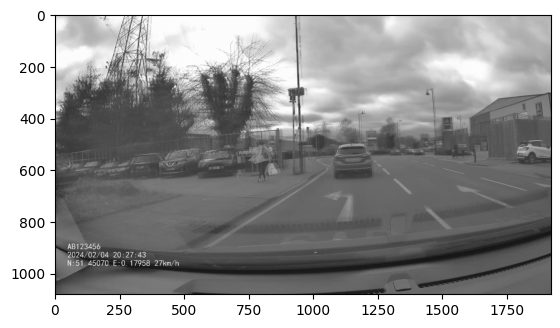

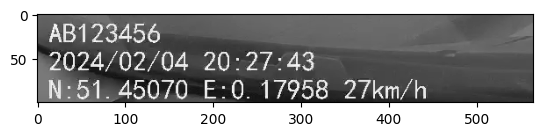

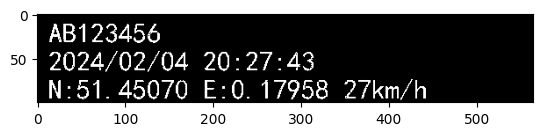

In [37]:
# Load the video
video_path = '20240204_202733F.ts'
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
cv2.destroyAllWindows()
cap.release()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(frame, cmap='gray')
plt.show()

roi = frame[875:975, 35:600]
plt.imshow(roi, cmap='gray')
plt.show()

_, roi = cv2.threshold(roi, 200, 255, cv2.THRESH_BINARY)
plt.imshow(roi, cmap='gray')
plt.show()


In [38]:
text = pytesseract.image_to_string(roi)
print("Extracted Text:", text)

Extracted Text: AB123456
2024/02/04 20:27:43
N:51. 45070 E:0. 17958 27km/h


In [39]:
print("Extracted Text:", repr(text))

Extracted Text: 'AB123456\n2024/02/04 20:27:43\nN:51. 45070 E:0. 17958 27km/h\n'


In [40]:
lines = text.splitlines()
# Get the last line
last_line = lines[-1]
print(last_line)
# Use regular expression to extract numeric values (including decimals)
numeric_values = re.findall(r'[-+]?\d*\.\d+|\d+', last_line)
print(numeric_values)
# Join the numeric values into a string
N = ".".join(numeric_values[0:2])
print("N=",N)
E = ".".join(numeric_values[2:4])
print("E=",E)

N:51. 45070 E:0. 17958 27km/h
['51', '45070', '0', '17958', '27']
N= 51.45070
E= 0.17958


In [41]:
def sample_frames(video_path, output_folder):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file.")
        return

    # Create output folder if it doesn't exist
    import os
    os.makedirs(output_folder, exist_ok=True)

    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break

        if frame_count % frame_rate == 0:
            # Write the sampled frame to the output folder
            frame_path = os.path.join(output_folder, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_path, frame)

        frame_count += 1

    cap.release()

In [42]:
# video_path = '20240204_202733F.ts'
# output_folder = 'output'
# sample_frames(video_path, output_folder)

## Version Sampling 1 frame per second

In [46]:
def get_gps(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    window = frame[875:975, 35:600]
    _, window = cv2.threshold(window, 200, 255, cv2.THRESH_BINARY)
    
    text = pytesseract.image_to_string(window)
    
    last_line = text.splitlines()[-1]
    numeric_values = re.findall(r'[-+]?\d*\.\d+|\d+', last_line)
    
    gps_n = float(".".join(numeric_values[0:2]))
    gps_e = float(".".join(numeric_values[2:4]))
    speed = int(numeric_values[-1])
    if len(numeric_values) != 5:
        speed = 0

    # return GPS N, GPS E, Speed
    return gps_n, gps_e, speed

In [47]:
def get_gps_from_video(video_path, save_frames):
    # Open the video file
    cap = cv2.VideoCapture(video_path)


    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    processing_rate = 1
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break

        if frame_count % (frame_rate / processing_rate) == 0:
            # Get the GPS data and speed
            gps_n, gps_e, speed = get_gps(frame)
            
            # code to control number of frames captured per second depending on speed
            if speed > 90:
                processing_rate = 3  # Process 3 frames per second
            elif speed > 60:
                processing_rate = 2  # Process 2 frames per second
            else:
                processing_rate = 1  # Process 1 frame per second
            
            
            print(gps_n, gps_e, speed)
            
            # output the saved frames for testing
            if save_frames:
                output_dir = "output"
                os.makedirs(output_dir, exist_ok=True)
                frame_filename = f"output/frame_{frame_count}.jpg"
                cv2.imwrite(frame_filename, frame)
            
            
        frame_count += 1

    cap.release()

In [48]:
video_path = '20240204_202733F.ts'
get_gps_from_video(video_path,save_frames=False)

51.4507 0.17958 27
51.45064 0.17953 30
51.45056 0.17943 31
51.4505 0.17933 32
51.45045 0.17923 31
51.45039 0.17915 31
51.45033 0.17905 31
51.45028 0.17895 30
51.45022 0.17885 30
51.45019 0.17874 30
51.45017 0.17863 28
51.45016 0.17852 24
51.45012 0.17843 22
51.45012 0.17836 21
51.45011 0.17827 19
51.4501 0.17819 17
51.45008 0.17815 14
51.45006 0.17812 11
51.45006 0.17806 8
51.45005 0.17805 6
51.45005 0.17803 5
51.45005 0.17801 3
51.45005 0.17798 2
51.45006 0.17798 0
51.45006 0.17798 1
51.45006 0.17797 1
51.45006 0.17797 0
51.45007 0.17797 0
51.45007 0.17797 1
51.45007 0.17796 1
51.45008 0.17796 2
51.45008 0.17795 2
51.45008 0.17794 2
51.45008 0.17793 2
51.45008 0.17793 2
51.45008 0.17792 1
51.45008 0.17792 1
51.45009 0.17793 1
51.45009 0.17793 0
51.4501 0.17793 0
51.4501 0.17793 0
51.45009 0.17794 0
51.45009 0.17794 1
51.45009 0.17794 0
51.45009 0.17794 0
51.45009 0.17795 0
51.45009 0.17795 0
51.45009 0.17795 0
